<font size=6>**Machine Learning Practises - Workshop**</font>

# Hyper-parameter tuning (low sample size)

**Hyperparameter tuning** == **select** the best hyperparameters of a model.

What "**best**" means?  As usual, the ones which return the best metric of performance on some test set.

For example, let's take the Random Forests **classifier** (RF**C**). Its <code>sklearn</code> implementation has 10 tunable hyperparameters (plus a few more that are related to the computational execution):

In [1]:
# Let's visualize the RF hyperparameters:
import inspect
from sklearn.ensemble import RandomForestClassifier

models = [RandomForestClassifier]

for m in models:
    hyperparams = inspect.signature(m.__init__)
    print(hyperparams)

(self, n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


Let's make it more complicated: let's add some preprocessing, which become part of the pipilene.

So now the model is not just the classifier, but:

> **Model** = **preprocessing + classifier**.

Recall that in general, a model contains _all_ the steps that go from the **input** to the **output** and that must be trained concurrently (**golden rule**):

<table><tr>
    <td width=640>
        <img src="images/Model.jpg">
        <center>
            <br>
            Figure 1.A.  A generic model template, containing several other steps apart from the Classifier.
            <br>
        </center>
    </td>
    <td width=256>
        <img src="images/I_Am_The_Model_Now.jpg">
        <center>
            <br>
            Figure 1.B.  Don't mess with the model.
            <br>
        </center>
    </td>
</tr></table>

Our preprocessing will be a **Principal Component** dimensionality reduction.

This also has an hyperparameter: the number of dimensions ($n_{dim}$) we want to reduce to.

How do we account for this?  We can do it simply by creating a **hyperparameter array**:

<table><tr>
    <td width=640>
        <img src="images/Model_Hyperparameters.jpg">
        <center>
            <br>
            Figure 2.  Hyperparameters for the generic model template shown above.
            Individual steps might be switched on/off by creating a proxy
            hyperparameter
            that can take a value of 1 if the specific step is used, or 0 if not.
            <br>
        </center>
    </td>
</tr></table>

NOTATION WARNING:

We can see these names used interchangeably, but their $un$-ambiguous definitions would be:

> - **configuration**: a specific set of hyperparameters (_defines which algorithms we pick and their tuning_)
> - **model**: a fitted configuration (_the same configuration trained on 2 different sets give birth to 2 different models_)
> - **learning method**: the procedure of finding the best-fitting model (_the "master" model_)

## Building the model

We can assemble the Model using [<code>sklearn.pipeline</code>](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

model = Pipeline([('PCA', PCA()), ('RFC', RandomForestClassifier())])

model

Pipeline(steps=[('PCA', PCA()), ('RFC', RandomForestClassifier())])

## Getting the data

Let's generate some synthetic data to play with.

In [3]:
from sklearn.datasets import make_classification
from prettytable import PrettyTable
import numpy as np
import pandas as pd

X, y = make_classification(n_samples=300, n_features=10, n_informative=7,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1, weights=None, flip_y=0.01,
                           class_sep=0.5, hypercube=True, shift=0.0, scale=1.0,
                           shuffle=True, random_state=42)

table = PrettyTable()
table.title = str('Data shape')
table.field_names = ['X', 'y']
table.add_row([np.shape(X), np.shape(y)])
print(table)

+--------------------+
|     Data shape     |
+-----------+--------+
|     X     |   y    |
+-----------+--------+
| (300, 10) | (300,) |
+-----------+--------+


In [4]:
# Splitting the sample for training and test:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

table = PrettyTable()
table.title = str('Data shape')
table.field_names = ['set', 'X', 'y']
table.add_row(['train', np.shape(X_train), np.shape(y_train)])
table.add_row(['test',  np.shape(X_test),  np.shape(y_test)])
print(table)

+----------------------------+
|         Data shape         |
+-------+-----------+--------+
|  set  |     X     |   y    |
+-------+-----------+--------+
| train | (210, 10) | (210,) |
|  test |  (90, 10) | (90,)  |
+-------+-----------+--------+


## Fitting and tuning the hyperparameters

We will use **Cross Validation with Tuning (CVT)** but reserve a **hold-out** test set for double-checking:

<table><tr>
    <td width=640>
        <img src="images/CV_holdout_split.png">
        <center>
            <br>
            Figure 3. Hold-out split.
            <br>
        </center>
    </td>
</tr></table>

- We will evaluate the average performance of **each configuration** over the folds.

- The **best** configuration will be the one yielding the best average performance.

<table><tr>
    <td width=1000>
        <img src="images/CV_k4_hyperpar.jpg">
        <center>
            <br>
            Figure 4. Cross Validation protocol, which will be applied to each configuration.
            <br>
        </center>
    </td>
</tr></table>

NOTE: In practice, we proceed it in this way:

1. We perform the first split into $k$ folds
2. We fit all models on the training folds, and record their performance on the validation fold
3. We repeat for the next split, until all possible splits are performed

### Hyperparameter search strategy

But which strategy shall we choose to explore the hyperparameter space? <br>
I.e., which parameter configurations shall we check?

    The hyperparameter space is potentially infinite.

One simple approach (and surprisingly effective!) is the:
> **Random Search**: Try randomly drawn parameter configurations until a pre-determined time limit

Here we will try the [<code>sklearn GridSearchCV</code>](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

> **Grid Search**: Set a range for the parameters and exhaustively search within it

First, we define the parameter limits:

In [5]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    "PCA__n_components": [2, 3, 5, 8],
    "RFC__n_estimators": [10, 20, 50, 100],
    "RFC__max_depth": np.arange(2, 10, 2),
}
'''
The syntax of this dictionary is:
    <label_as_you_defined_in_pipe>__<parameter_name_as_in_sklearn_documentation>
Type, e.g.:
    RandomForestClassifier?
to visualize all the possible parameters    
''';

display(param_grid)

{'PCA__n_components': [2, 3, 5, 8],
 'RFC__n_estimators': [10, 20, 50, 100],
 'RFC__max_depth': array([2, 4, 6, 8])}

We created a grid over 3 hyperparameters (and let the rest to keep the default values), and sampled only 4 values for each of them.

Keep in mind that the Grid Search is extremely time consuming $\rightarrow$ How many models we need to train?

NOTE: See the [<code>sklearn</code> tutorial](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) on how to combine a Grid Search with a pipeline model.


Let's now implement the **search strategy**, including the Cross Validation:

In [6]:
search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',
                      n_jobs=-1, refit=True, return_train_score=True)
'''
Read this as:
    "Perform a Grid Search on Model <model> creating the configurations using
    the parameter grid <param_grid>, and Cross Validation with 5 folds.
    Use accuracy to evaluate the configurations.
    
refit = True
    Will refit the best found model on the whole dataset, which is the actual
    model we shall use for prediction on unseen data!
    By doing that, after the training is complete, we can just predict by 
    using the standard sklearn syntax:
    
        yhat = search.best_estimator_predict(X)
''';

### Fitting the Model

This uses the usual <code>sklearn</code> syntax, but on the <code>search</code> object.

In [7]:
%%time
search.fit(X_train, y_train)
# NOTE: We pass the whole dataset, the CV fold splitting is done internally!

print("Best configuration:")
print(search.best_params_)

print("\nBest configuration: mean CV score = %0.3f\n" % search.best_score_)
# NOTE: The best configuration is the one with the best _mean_ score across
#       folds, not the one with the absolute best score

Best configuration:
{'PCA__n_components': 8, 'RFC__max_depth': 8, 'RFC__n_estimators': 100}

Best configuration: mean CV score = 0.871

CPU times: user 517 ms, sys: 54.7 ms, total: 572 ms
Wall time: 5.46 s


### Plot twist: the assessment method is _wrong_!

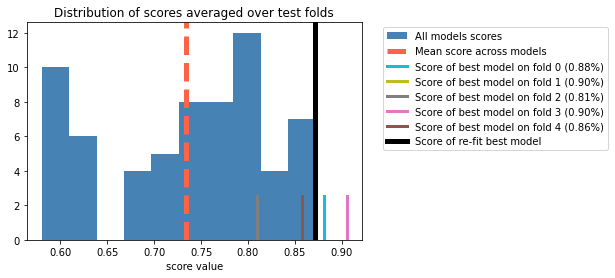

In [8]:
# > Check distribution of the scores

# GridSearch stores the test scores across the folds under the
# "mean_test_score" entry of the trained <search.cv_results_> dictionary.
# They are indexed by configuration, e.g., entry 0 refers to configuration 0

mean_test_scores = search.cv_results_['mean_test_score']
# mean scores across test sets (== validation sets, in the case of CV), one per model

best_score_folds = [search.cv_results_['split'+str(i)+'_test_score'][search.best_index_] for i in range(search.n_splits_)]
# all scores of best model, one per fold

# Let's plot the histogram of the scores obtained by each model:
# NOTE: The score of a model is itself averaged over the k validation folds

from matplotlib import pyplot as plt

plt.title('Distribution of scores averaged over test folds')
plt.hist(mean_test_scores, color='steelblue', label='All models scores')
plt.axvline(x=np.mean(mean_test_scores), lw=5, ls='--', c='tomato', label='Mean score across models')

cmap = plt.cm.get_cmap('tab10_r', 10)
for i, best_score_fold in enumerate(best_score_folds):
    plt.axvline(x=best_score_fold, ymin=0, ymax=0.2, lw=3, ls='-', c=cmap(i), \
                label='Score of best model on fold %s (%.2f%%)' % (str(i), best_score_fold))
plt.axvline(x=search.best_score_, lw=5, ls='-', c='black', \
            label='Score of re-fit best model')

plt.xlabel('score value')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

WARNING: In <code>GridSearchCV</code> we set <code>refit=True</code>.

&emsp; Hence, the "**best model**" is the best configuration re-fit on the whole dataset, but its "**best score**" is _still_ the average of the cross-validated scores.<br>
&emsp; _(See discussion [here](https://stackoverflow.com/questions/50232599/interpreting-sklearns-gridsearchcv-best-score))_

<u>What is the problem?</u>

The best score is the performance of a model selected using that very performance!

> We looked at the future (validation folds) to select the model $\rightarrow$ violation of **Golden Rule**!

a.k.a. **Winner's curse**: we cannot be sure that the best model is indeed the best for unseen data.

<u>Demonstration</u>

Let's say we test $i$ = {0, 1, .. $n$} models, each returning an average score $\hat{S_{i}}$ from the CV.

- The **CVT method selects** the model returning the **best average score**: $max$($\hat{S_{0}}$ .. $\hat{S_{n}}$).<br>
  _$\rightarrow$ Let's say that the best model is found at index $i = k$_.<br><br>

- If we repeated the CV experiment **many times**, with different data, which would be the **expectation on the best score**?

$$ \mathbb{E}(max(\hat{S_{0}} .. \hat{S_{n}})) $$

- From Jensens' inequality we know that, for every **$i$**\:

$$ \mathbb{E}(max(\hat{S_{0}} .. \hat{S_{n}})) \ge \mathbb{E}(\hat{S_{i}}) $$ 

- Let's focus on our best model, i.e. $i = k$:

\begin{equation*}
\mathbb{E}(max(\hat{S_{0}} .. \hat{S_{n}})) \ge \mathbb{E}(\hat{S_{k}})
\label{equation:expectation} \tag{1}
\end{equation*}

Therefore our selection method, i.e. $max$($\hat{S_{0}}$ .. $\hat{S_{n}}$), is expected to return a **larger** score than the _true_ expected score for that model, i.e. $\mathbb{E}(\hat{S_{k}})$.
$\blacksquare$

_(See discussion [here](https://stats.stackexchange.com/questions/480984/why-cross-validation-gives-biased-estimates-of-error))_

<table><tr>
    <td width=128>
        <img src="images/Deal_With_It.png">
    </td>
</tr></table>

In [9]:
# And in fact, when we apply the model to the test set ...
import sklearn.metrics
print("Accuracy score on test set: %.2f%%" % sklearn.metrics.accuracy_score(y_test, search.predict(X_test)))

Accuracy score on test set: 0.80%


<u>Conclusions:</u>

CV is ok for assessing the variance of a **given** model when trained/tested on different sets, but ...

When performing **model selection**:

- The validation set(s) in the CV can only be used to **select** the best configuration.

- You _cannot_ use the validation set to select the model **and** evaluate the performance!

- To assess the performance, you need a **test set**.

  Or else you are gonna bias the estimation!

# Model selection and assessment $-$ the right way

Let's formulate the problem in the general case of **Model Selection**, i.e. select among a variety of models and report their performance.

_NOTE: The line between **hyperparameter tuning** and model **model selection** is in fact very thin, since $-$ as we have seen $-$ a model can be seen as a configuration which might "switch" on or off a specific algorithm._

<font size=3><u>**Unbiased estimations**</u><font>

In general, we would like a learning method for selecting the best model and fitting, which is not biased in its performance estimation:
- If we have many, many data $\rightarrow$ CV + hold-out set

- If we have few data, need to cycle through $\rightarrow$ CV + **Nested Cross Validation (NCV)**!

> CV $\leftarrow$ gives us the **best model**

> NCV $\leftarrow$ gives us **performance assessment** of our CV method

<font size=3><u>**How NCV works**</u><font>

First of all, let's think of CVT as a **learning method**:

- As an **input**, it takes the data
- **Inside**, it learns to select the best model
- As an **output**, it returns the best model

<table><tr>
    <td width=640>
        <img src="images/CVT_learning_method.png">
        <center>
            <br>
            Figure 5. Cross Validation with Tuning as a learning method.
            <br>
        </center>
    </td>
</tr></table>

<u>Issue:</u> In CVT, we don't have a test set to independently estimate the selected model performance.

So why not add one more **outer** cross-validation which isolates a test set at each split?!

<table><tr>
    <td width=640>
        <img src="images/NCV_k4.jpg">
        <center>
            <br>
            Figure 6. Nested Cross Validation protocol.
            <br>
        </center>
    </td>
</tr></table>

Basically, NCV cross-validates the CVT!

The **performance estimate** will be $\rightarrow$ the **average performance over the outer loop**.

- - -

<font size=3><u>**Important**</u><font>

Notice how the model (configuration) selected by each CVT **can be different**!
 
That means that the output distribution of performances is generated by different fitted algorithms!
It does _not_ refer to the specific best configuration!
 
In practice, the actual configuration of the final model is not so relevant, what is relevant is that <u>we can fit the input data with <_this much_> accuracy</u>.
<br>

<details>
<summary><b>[Spoiler]</b></summary>
<table><tr>
    <td width=640>
        <img src="images/Model_Not_Important.jpg">
    </td>
</tr></table>
</details>

<font size=3><u>**Final model**</u><font>

    What is the final model? The one with the best score in outer loop?

NO $\rightarrow$ NCV only assesses the **performance of our learning method** (CVT).    

If you want the best model, just run **CVT on all the data**.
    
See discussion [here](https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection).

<font size=3><u>**Useful links**</u><font>

[ - ] NCV with [<code>sklearn</code>](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

[ - ] A marvellous [introductive guide](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) by J. Brownlee

[ - ] Final model: better retrain on the **best** configuration, or on an **ensamble** of the best inner models?
See the considerations [here](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/).

## Let's try NCV to assess our learning method

Two nice methods to implement CV for multpile classifiers can be found [here](https://stackoverflow.com/questions/23045318/grid-search-over-multiple-classifiers).

In [10]:
from termcolor import colored, cprint
# NCV utilities:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from pipelinehelper import PipelineHelper
from collections import OrderedDict
# Scalers:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
# Classifiers:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
# Metrics:
import sklearn.metrics
# Ignore sklearn warnings (remove when ready!):
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [11]:
# Nested CV setup variables --------------------------------------------------
# Use a larger value for the outer loop (e.g. 10) than for the inner loop (e.g. 3) -- See:
#     https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation
n_splits_outer = 5 #10
# number of folds in outer CV 
n_splits_inner = 3
# number of folds in inner CV 
#-----------------------------------------------------------------------------

In [12]:
def inner_CV(X_train, y_train, n_splits_inner, verbose=0):
    '''
    Inner CV loop, implemented using PipelineHelper: 
        https://github.com/bmurauer/pipelinehelper
        
    Parameters:
    -----------
    X_train, y_train : np.ndarray, np.array
        Data over which to perform the inner CV.
    n_splits_inner : int
        Number of k-folds for the inner loop.
    '''
    
    '''Define here all possible models that you want to attemp:
    
        In particular, this pipeline trains, for each CV iteration, one
        combination of:
       - a scaler (sampled between StandardScaler or MaxAbsScaler)
       - a classifier (sampled between LinearSVC or RandomForestClassifier)
    '''
    
    models = Pipeline([
        ('scaler', PipelineHelper([
            ('std', StandardScaler()),
            ('max', MaxAbsScaler()),
        ])),
        ('classifier', PipelineHelper([
            ('svm', LinearSVC()),
            ('rf', RandomForestClassifier()),
        ])),
    ])

    '''Define here the parameter you want to sample, for each scaler
    and each classifier:
    
        In particular, this pipeline tries:
        - using mean and/or standard deviation to scale the data
        - different C parameters for the Support Vector machine Classifier 
        - different n_estimators for the Random Forsests
        
        NOTE1: MaxAbsScaler takes no parameters!
        NOTE2: You can just through in all the parameters, the PipelineHelper
               will take care to attribute them to the correct algorithm
    '''
    
    param_grid = {
        'scaler__selected_model': models.named_steps['scaler'].generate({
            'std__with_mean': [True, False],
            'std__with_std': [True, False],
        }),
        'classifier__selected_model': models.named_steps['classifier'].generate({
            'svm__C': [0.1, 1.0],
            'rf__n_estimators': [20, 100],
        })
    }
    
    search = GridSearchCV(models, param_grid, scoring='accuracy',
                        cv=n_splits_inner, refit=True, verbose=verbose)

    result = search.fit(X_train, y_train)
    # NOTE: After GridSearch finds the best model, it re-fits it on the whole
    #       X_train set and returns it as the best model
    
    return result

In [13]:
%%time

def run_NCV(X_train, y_train, n_splits_outer, n_splits_inner, inner_CV=inner_CV):

    # Configuring the outer CV procedure:
    cv_outer = KFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

    outer_scores = OrderedDict()
    # dictionary of scores for the best models found at each outer iteration <indexed by outer CV iteration>
    best_inner_models = []
    # list of trained best models found at each inner iteration <indexed by outer CV iteration>

    for i, (train_ix, test_ix) in enumerate(cv_outer.split(X_train)):
    # outer CV loop
    # NOTE: We will only use the training set for the NCV, and further split it.
    #       We want to keep the hold-out set for the final check!

        cprint('> Outer iteration %s [of %s]' % (i+1, n_splits_outer), 'red')

        # Splitting outer CV data in train and test:
        X_outer_train, X_outer_test = X_train[train_ix, :], X_train[test_ix, :]
        y_outer_train, y_outer_test = y_train[train_ix]   , y_train[test_ix]

        # > Executing the search (i.e., the inner CV loop):
        result = inner_CV(X_outer_train, y_outer_train, n_splits_inner)
        # NOTE: Inside the inner CV, X_outer_train will be further split in the
        #       inner train and validation sets by GridSearchCV

        # Getting the best performing model from the inner iteration:
        best_inner_model = result.best_estimator_

        # > Evaluating model on the test fold

        # Predicting labels on the outer test fold:
        yhat_outer_test = best_inner_model.predict(X_outer_test)

        # Scoring the model on test fold:
        score = sklearn.metrics.accuracy_score(y_outer_test, yhat_outer_test)

        best_inner_models.append(best_inner_model)

        # Storing score result for current [outer CV] fold:
        outer_scores[str(i)] = OrderedDict({  
            'score': score,
            'cfg': result.best_params_
        })

        print('\tScore: valid = %.2f | test = %.2f' % (np.abs(result.best_score_), score))
        print('\tSelected config: %s' % result.best_params_, end='\n\n')

    # Converting <outer_models> to a dataframe, for better visualization:
    df_score = pd.DataFrame([outer_score['score'] for key, outer_score in outer_scores.items()], columns=['score'])
    df_cfg   = pd.DataFrame([outer_score['cfg'] for key, outer_score in outer_scores.items()])
    df_outer_scores = pd.concat([df_score, df_cfg], axis=1)

    # Summarizing the estimated performance of the model:
    print()
    print('Mean test score: %.3f (+/-%.3f)\n' %
          (np.mean(df_outer_scores['score']), np.std(df_outer_scores['score'])))
    
    return df_outer_scores, best_inner_models

df_outer_scores, best_inner_models = \
    run_NCV(X_train, y_train, n_splits_outer, n_splits_inner, inner_CV=inner_CV)

> Outer iteration 1 [of 5]
	Score: valid = 0.85 | test = 0.81
	Selected config: {'classifier__selected_model': ('rf', {'n_estimators': 100}), 'scaler__selected_model': ('max', {})}

> Outer iteration 2 [of 5]
	Score: valid = 0.83 | test = 0.86
	Selected config: {'classifier__selected_model': ('svm', {'C': 0.1}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': False})}

> Outer iteration 3 [of 5]
	Score: valid = 0.79 | test = 0.88
	Selected config: {'classifier__selected_model': ('rf', {'n_estimators': 100}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}

> Outer iteration 4 [of 5]
	Score: valid = 0.86 | test = 0.79
	Selected config: {'classifier__selected_model': ('svm', {'C': 0.1}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}

> Outer iteration 5 [of 5]
	Score: valid = 0.83 | test = 0.76
	Selected config: {'classifier__selected_model': ('svm', {'C': 0.1}), 'scaler__selected_model': ('std', {'with_mean': True, 

### Performances

In [14]:
print('Outer CV configurations:')
display(df_outer_scores)

Outer CV configurations:


,score,classifier__selected_model,scaler__selected_model
0,0.809524,"(rf, {'n_estimators': 100})","(max, {})"
1,0.857143,"(svm, {'C': 0.1})","(std, {'with_mean': True, 'with_std': False})"
2,0.880952,"(rf, {'n_estimators': 100})","(std, {'with_mean': True, 'with_std': True})"
3,0.785714,"(svm, {'C': 0.1})","(std, {'with_mean': True, 'with_std': True})"
4,0.761905,"(svm, {'C': 0.1})","(std, {'with_mean': True, 'with_std': True})"


<u>Final remarks:</u>

A comparison of the expectiation values for repeated experiments with CV and NCV is provided by this <code>sklearn</code> [notebook](https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html) (remember Equation 1?).

Notice though that the code in that notebook does not allow to easily generalize to combination of algorithms, e.g. scaler $+$ classifier, or even to multiple classifiers.  For that purpose, use the <code>inner_CV</code> function above. 

<table><tr>
    <td width=400>
        <img src="images/NCV_vs_CV.png">
        <center>
            <br>
            Figure 7. Comparison of accuracy estimates from repeated Nested Cross Validation and Cross Validation.
            <br>
            (From <a href="https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html">here</a>)
            <br>
        </center>
    </td>
</tr></table>

# EXERCISE 1: Create your own NCV

You must:

- use <code>RandomizedSearchCV</code> (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html))

  _instead of the <code>GridSearchCV</code> we used before.
  You can assume a uniform distribution for all the parameters, to start with._<br><br>
  
  - to sample integers: [<code>scipy.stats.randint</code>](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)
  - to sample floats: [<code>scipy.stats.uniform</code>](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html)
  - or pass a list of possible values for categorical data
  <br><br>
  
- use any collection of <code>sklearn</code> classifiers, and associated hyperparameters, you like (a complete list [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html))

  _but watch your clock!  The more classifiers you put into the NCV, the more time it will take!_<br><br>
  
- [Optional] try with different numbers of inner and outer folds.

In [15]:
from termcolor import colored, cprint
# NCV utilities:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from pipelinehelper import PipelineHelper
from collections import OrderedDict
# Scalers:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.preprocessing import QuantileTransformer
# Classifiers:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
# Metrics:
import sklearn.metrics
# Ignore sklearn warnings (remove when ready!):
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [16]:
# Nested CV setup variables --------------------------------------------------
# Use a larger value for the outer loop (e.g. 10) than for the inner loop (e.g. 3) -- See:
#     https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation
n_splits_outer = 5
# number of folds in outer CV 
n_splits_inner = 3
# number of folds in inner CV 
#-----------------------------------------------------------------------------

In [17]:
from scipy.stats import uniform
from scipy.stats import randint

def my_inner_CV(X_train, y_train, n_splits_inner, verbose=0):
    
    # edit here ...
    
    result = search.fit(X_train, y_train)
    
    return result

In [ ]:
%%time
df_outer_scores, best_inner_models = \
    run_NCV(X_train, y_train, n_splits_outer, n_splits_inner, inner_CV=my_inner_CV)

In [19]:
# Copy the rest of the code from the previous Section :D

## EXERCISE 1.2: Find the final model via an additional CVT

And report the score on the hold-out test set.

In [20]:
# Ctrl+C Ctrl+V is your friend.
#
# If you use OSX ... oh well, not my fault.

# How to pick the hyperparameters/algorithms to explore?

The possible varaints one can try when exploring models are potentially very large.<br>
We cannot afford to spend infinite time fitting!

Solutions include:
 - consider previous knowledge of models performance in the learning method (**meta features**)
 - **early dropping** of poorly performing models (_not to fit them at every iteration_)
 - address the whole issue as an **optimization problem**
 
 There are plenty of optimization algorithms, and we leave it up to you to study them.
 
 > A safe all-round bet might be the successful **Bayesian Optimization**: [here](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) you can find a good introduction.

<table><tr>
    <td width=640>
        <img src="images/Know_More.jpg">
        <center>
            <br>
            Figure 8.  Check Bayesian Optimization before the insects take over.
            <br>
        </center>
    </td>
</tr></table>

# Auto ML

> **Auto ML**: Automated hyperparameter search, and model selection, with techniques
    allowing to select which algorithms to try out (_i.e., avoiding extensive search_).

There are many services providing auto ML out there $-$ here we will look at the 
<code>[auto-sklearn](https://automl.github.io/auto-sklearn/master/)</code>
implementation.

In [21]:
%%time
import autosklearn.classification

# Defining the automl learning method:
automl = autosklearn.classification.AutoSklearnClassifier(
                                ensemble_size=1, time_left_for_this_task=120)
# Fitting (this will take at most <time_left_for_this_task> seconds):
automl.fit(X_train, y_train)

/data/software/anaconda3/envs/autoML/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/data/software/anaconda3/envs/autoML/lib/python3.9/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


CPU times: user 52.3 s, sys: 1.09 s, total: 53.3 s
Wall time: 1min 55s


AutoSklearnClassifier(ensemble_size=1, per_run_time_limit=12,
                      time_left_for_this_task=120)

In [22]:
print(automl.sprint_statistics())

# Predicting labels of test set:
import sklearn.metrics

yhat_test = automl.predict(X_test)

print("Accuracy score on test set: %.2f%%" % sklearn.metrics.accuracy_score(y_test, yhat_test))

auto-sklearn results:
  Dataset name: 789bbba3-02fa-11ed-9a7d-1002b5312d0b
  Metric: accuracy
  Best validation score: 0.928571
  Number of target algorithm runs: 54
  Number of successful target algorithm runs: 54
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0

Accuracy score on test set: 0.83%


## Inspecting the best model details

Let's have a look into the model which has been selected out of all the models that the <code>auto-sklearn</code> has tried out.

In [23]:
from IPython.display import display

print('=== Selected model ===')
display(automl.show_models())

=== Selected model ===


{43: {'model_id': 43,
  'rank': 1,
  'cost': 0.0714285714285714,
  'ensemble_weight': 1.0,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7fd2f259adf0>,
  'balancing': Balancing(random_state=1, strategy='weighting'),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7fd2f25d5850>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7fd341128d30>,
  'sklearn_classifier': MLPClassifier(alpha=8.045852733635899e-06, beta_1=0.999, beta_2=0.9,
                early_stopping=True, hidden_layer_sizes=(112, 112),
                learning_rate_init=0.00020139694272470796, max_iter=32,
                n_iter_no_change=32, random_state=1, verbose=0, warm_start=True)}}

In [24]:
for model_id, model in automl.show_models().items():
    print('--- Details of the "data_preprocessing" ---')
    display(model['data_preprocessor'].__dict__)
    
    print('--- Details of the "balancing" ---')
    display(model['balancing'].__dict__)
    
    print('--- Details of the "feature_preprocessor" ---')
    display(model['feature_preprocessor'].__dict__)    

--- Details of the "data_preprocessing" ---


{'random_state': 1,
 'choice': FeatTypeSplit(column_transformer=ColumnTransformer(sparse_threshold=0.0,
                                                    transformers=[('numerical_transformer',
                                                                   NumericalPreprocessingPipeline(config=Configuration:
   imputation:strategy, Value: 'median'
   rescaling:__choice__, Value: 'standardize'
 , dataset_properties={'signed': False, 'sparse': False}, exclude={}, include={}, init_params={}, steps=[('imputation', Num...
                       'categorical_transformer:category_coalescence:__choice__': 'no_coalescense',
                       'numerical_transformer:imputation:strategy': 'median',
                       'numerical_transformer:rescaling:__choice__': 'standardize'},
               feat_type={0: 'numerical', 1: 'numerical', 2: 'numerical',
                          3: 'numerical', 4: 'numerical', 5: 'numerical',
                          6: 'numerical', 7: 'numerical', 8:

--- Details of the "balancing" ---


{'strategy': 'weighting', 'random_state': 1, 'fitted_': True}

--- Details of the "feature_preprocessor" ---


{'random_state': 1,
 'choice': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                    random_state=1),
 'new_params': {'degree': 2,
  'include_bias': 'True',
  'interaction_only': 'False',
  'random_state': 1},
 'fitted_': True}

## Final remarks on autoML

You can use <code>auto-sklearn</code> almost blindly $-$ but $-$ to understand the results ...

$\rightarrow$ Read the docs!